# BERT Sentiment Analysis

## Import Libraries

In [21]:
import pandas as pd 
import numpy as np 

import torch 
import torch.nn as nn 
import torch.nn.functional as F 

from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModel 
from transformers import DataCollatorWithPadding

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score

from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt 
import seaborn as sns

import swifter

## Load Data

In [2]:
data = load_dataset('yelp_polarity', cache_dir = None)
data.set_format('pandas')

In [3]:
train = data['train'][:]
eval = data['test'][:]

val, test = train_test_split(eval, test_size = 0.5, random_state = 42, stratify = eval['label'])

## Load Tokenizer

In [4]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

## Explore Data

In [5]:
print('Number of training examples:', len(train))
print('Number of validation examples:', len(val))
print('Number of testing examples:', len(test))

Number of training examples: 560000
Number of validation examples: 19000
Number of testing examples: 19000


In [6]:
print('Label distribution in training set:')
print(train['label'].value_counts(normalize = True))

print('Label distribution in validation set:')
print(val['label'].value_counts(normalize = True))

print('Label distribution in testing set:')
print(test['label'].value_counts(normalize = True))

Label distribution in training set:
label
0    0.5
1    0.5
Name: proportion, dtype: float64
Label distribution in validation set:
label
1    0.5
0    0.5
Name: proportion, dtype: float64
Label distribution in testing set:
label
1    0.5
0    0.5
Name: proportion, dtype: float64


Pandas Apply: 100%|██████████| 560000/560000 [00:01<00:00, 282536.58it/s]


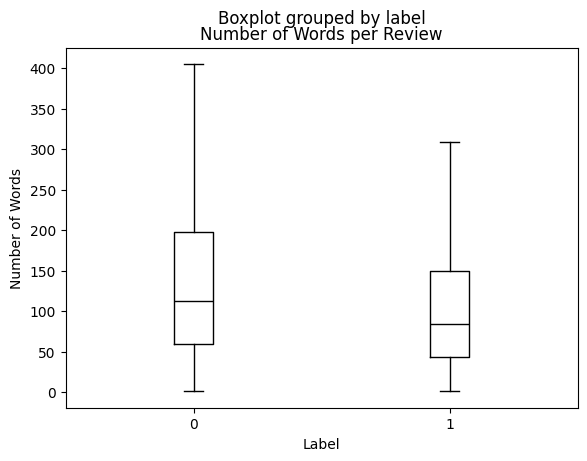

In [7]:
train['num_words'] = train.text.swifter.apply(lambda x: len(x.split()))

train.boxplot('num_words', by = 'label', showfliers = False, color = 'black', grid = False)
plt.title('Number of Words per Review') 
plt.xlabel('Label') 
plt.ylabel('Number of Words') 
plt.show()

Token indices sequence length is longer than the specified maximum sequence length for this model (1019 > 512). Running this sequence through the model will result in indexing errors


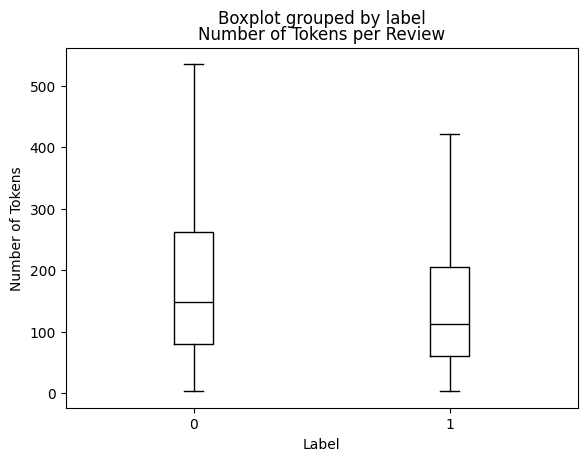

In [8]:
encoded = tokenizer(
    train.text.tolist(), 
    truncation = False, 
    padding = False, 
    return_length = True
)

train['num_tokens'] = encoded['length']

train.boxplot('num_tokens', by = 'label', showfliers = False, color = 'black', grid = False)
plt.title('Number of Tokens per Review') 
plt.xlabel('Label') 
plt.ylabel('Number of Tokens') 
plt.show()

In [9]:
print('Max Length Accepted by distilBERT:', tokenizer.model_max_length)

Max Length Accepted by distilBERT: 512


## Define Model 

In [15]:
class CustomClassifier(nn.Module): 
    def __init__(self, num_classes, classifier_dim, dropout = 0.1, use_cls = True, freeze_bert = True, device = 'cuda'): 
        super().__init__()
        self.use_cls = use_cls
        self.dropout = dropout
        self.classifier_dim = classifier_dim 
        self.device = device 
        self.bert = AutoModel.from_pretrained('distilbert-base-uncased')

        if freeze_bert: 
            for param in self.bert.parameters(): 
                param.requires_grad = False 
        
        hidden_size = self.bert.config.hidden_size 

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, classifier_dim), 
            nn.ReLU(), 
            nn.Dropout(self.dropout), 
            nn.Linear(classifier_dim, num_classes) 
        )

    def forward(self, input_ids, attention_mask): 
        outputs = self.bert(input_ids = input_ids, attention_mask = attention_mask)
        hidden_states = outputs.last_hidden_state 

        if self.use_cls: 
            pooled_output = hidden_states[:, 0, :]
        else: 
            mask = attention_mask.unsqueeze(-1).expand(hidden_states.size())
            masked_hidden = hidden_states * mask 
            summed = masked_hidden.sum(1) 
            counts = attention_mask.sum(1).clamp(min = 1e-9) 
            pooled_output = summed / counts 

        return self.classifier(pooled_output) 


## Training and Evaluation Functions

In [16]:
def train_one_epoch(model, train_dataloader, optimizer, criterion, device='cuda', print_every=100): 
    model.train()

    pred_probas = []
    preds = []
    all_labels = []

    running_loss = 0.0
    total_samples = 0

    for i, batch in enumerate(train_dataloader): 
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Predictions
        prob = F.softmax(logits, dim = 1)[:, 1].detach().cpu().numpy()
        pred = torch.argmax(logits, dim = 1).detach().cpu().numpy()
        labs = labels.detach().cpu().numpy()

        pred_probas.extend(prob)
        preds.extend(pred)
        all_labels.extend(labs) 

        batch_size = input_ids.size(0)
        running_loss += loss.item() * batch_size
        total_samples += batch_size

        if i % print_every == 0: 
            print(f'Batch {i + 1} Loss: {loss:.4f}')

    return running_loss / total_samples, pred_probas, preds, all_labels

        
        


In [17]:
def evaluate_one_epoch(model, val_dataloader, criterion, device = 'cuda'): 
    model.eval()

    pred_probas = []
    preds = []
    all_labels = []

    running_loss = 0.0 
    total_samples = 0
    
    with torch.no_grad(): 
        for i, batch in enumerate(val_dataloader): 
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask) 

            loss = criterion(logits, labels) 

            prob = F.softmax(logits, dim = 1)[:, 1].cpu().numpy()
            pred = torch.argmax(logits, dim = 1).cpu().numpy()
            labs = labels.cpu().numpy()

            pred_probas.extend(prob)
            preds.extend(pred)

            batch_size = input_ids.size(0)
            running_loss += loss.item() * batch_size
            total_samples += batch_size

    return running_loss / total_samples, pred_probas, preds, all_labels

In [32]:
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, epochs, device, patience = 3, print_every = 100, scheduler = None): 
    train_losses = []
    val_losses = []

    train_auprcs = []
    val_auprcs = []

    best_val_loss = float('-inf') 
    no_improve_epochs = 0
    
    for epoch in range(epochs): 
        print(f'Epoch {epoch + 1} / {epochs}')
        print('-' * 30) 

        train_loss, train_pred_probas, train_preds, train_labels = train_one_epoch(model, train_dataloader, optimizer, criterion, device, print_every) 
        val_loss, val_pred_probas, val_preds, val_labels = evaluate_one_epoch(model, val_dataloader, criterion, device) 

        train_auprc = average_precision_score(train_labels, train_pred_probas) 
        val_auprc = average_precision_score(val_labels, val_pred_probas) 

        if scheduler: 
          scheduler.step(val_loss) 

        current_lr = optimizer.param_groups[0]['lr']
        
        print(f'Train Loss: {train_loss:.4f} | Train AUPRC: {train_auprc:.4f} | Val Loss: {val_loss:.4f} | Val AUPRC: {val_auprc:.4f} | LR: {current_lr:.2e}')

        train_losses.append(train_loss) 
        val_losses.append(val_loss) 

        train_auprcs.append(train_auprc) 
        val_auprcs.append(val_auprcs) 

        if val_loss < best_val_loss: 
            best_val_loss = val_loss 
            no_improve_epochs = 0 
            best_model_state = model.state_dict()

        else: 
            no_improve_epochs += 1
            print(f'No improvement in validation loss for {no_improve_epochs} epochs.')

            if no_improve_epochs >= patience: 
                print(f'Early stopping triggered after {epoch + 1} epochs.')
                break 

    model.load_state_dict(best_model_state) 

    return train_losses, train_auprcs, val_losses, val_auprcs 
    

## Model Setup

In [26]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

BATCH_SIZE = 32 
model = CustomClassifier(
    num_classes = 2, 
    classifier_dim = 128,
    dropout = 0.1, 
    use_cls = True, 
    freeze_bert = True, 
    device = device 
)

optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode = 'min', 
    factor = 0.5, 
    patience = 2, 
    verbose = False
)
criterion = nn.CrossEntropyLoss()

model.to(device) 

CustomClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linea

### Create Dataset

In [23]:
dataset = DatasetDict({
    'train': Dataset.from_pandas(train.drop(columns = ['num_words', 'num_tokens'])),
    'val': Dataset.from_pandas(val.reset_index(drop = True)),
    'test': Dataset.from_pandas(test.reset_index(drop = True))
})

In [24]:
def tokenize_function(example):
    return tokenizer(
        example['text'],
        truncation = True,
        max_length = 512,
        padding = False
    )

tokenized_dataset = dataset.map(tokenize_function, batched = True, remove_columns = ['text'])
tokenized_dataset = tokenized_dataset.rename_column('label', 'labels')
tokenized_dataset.set_format(type = 'torch', columns = ['input_ids', 'attention_mask', 'labels'])

Map: 100%|██████████| 19000/19000 [00:07<00:00, 2403.43 examples/s] 


### Create Dataloader

In [28]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

train_dataloader = DataLoader(tokenized_dataset['train'], batch_size = 32, shuffle = True, collate_fn = data_collator)
val_dataloader = DataLoader(tokenized_dataset['val'], batch_size = 32, shuffle = False, collate_fn = data_collator)
test_dataloader = DataLoader(tokenized_dataset['test'], batch_size = 32, shuffle = False, collate_fn = data_collator)

## Train Model

In [33]:
train_losses, train_auprcs, val_losses, val_auprcs = train_model(model, train_dataloader, val_dataloader, optimizer, criterion, 30, device, patience = 4, print_every = 100, scheduler = scheduler)

Epoch 1 / 30
------------------------------
Batch 1 Loss: 0.6828
Batch 101 Loss: 0.2007


KeyboardInterrupt: 